In [ ]:
pip install tensorflow-ranking

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 3.9 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-serving-api to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 92.8 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.15.0
    Uninstalling tensorflow-2.15.0:
      Successfully uninstalled tensorflow-2.15.0


In [ ]:
import json
import torch
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
from torchvision import transforms, models
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from tensorflow_ranking.python.keras.metrics import MeanAveragePrecisionMetric
import tensorflow_ranking as tfr
from PIL import Image
import numpy as np
import random
import torch.nn.functional as F
from torchvision import transforms as T
import os
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from sklearn.metrics import average_precision_score
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import torchvision.transforms.functional as TF
import torch
torch.cuda.empty_cache()
# Set random seed for reproducibility
random.seed(4)
np.random.seed(4)
torch.manual_seed(4)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Dataset class
class LeishmaniaDataset(Dataset):
    def __init__(self, labels_dir, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels_dir = labels_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(self.img_dir), key=lambda x: int(os.path.splitext(x)[0]))
        self.annotation_files = sorted(os.listdir(self.labels_dir), key=lambda x: int(os.path.splitext(x)[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        annotation_path = os.path.join(self.labels_dir, self.annotation_files[idx])
        image = Image.open(img_path).convert("RGB")

        with open(annotation_path) as f:
            annotation = json.load(f)

        boxes = [shape['points'][0] + shape['points'][1] for shape in annotation['shapes'] if shape['shape_type'] == 'rectangle']
        boxes = self.filter_boxes(boxes)

        labels = torch.ones((len(boxes),), dtype=torch.int64)

        if len(boxes) > 0:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            boxes[:, 0::2].clamp_(min=0, max=image.width)
            boxes[:, 1::2].clamp_(min=0, max=image.height)
            boxes[:, [0, 2]] = torch.sort(boxes[:, [0, 2]], dim=1)[0]
            boxes[:, [1, 3]] = torch.sort(boxes[:, [1, 3]], dim=1)[0]
        else:
            boxes = torch.empty((0, 4), dtype=torch.float32)

        target = {'boxes': boxes, 'labels': labels, 'image_id': torch.tensor([idx])}

        if self.transform:
            image = self.transform(image)

        return image, target

    def filter_boxes(self, boxes, min_size=5):
        filtered_boxes = []
        for box in boxes:
            x1, y1, x2, y2 = box
            if (x2 - x1) > min_size and (y2 - y1) > min_size:
                filtered_boxes.append(box)
        if len(filtered_boxes) > 0:
            return filtered_boxes
        else:
            return []

In [ ]:
# Collate function
def collate_fn(batch):
    return tuple(zip(*batch))

# Visualize dataset sample
def visualize_dataset_sample(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 10))

    for i, idx in enumerate(indices):
        image, target = dataset[idx]
        boxes = target['boxes'].cpu().numpy()

        # Convert PIL Image to numpy array for visualization
        image = np.array(image)

        axes[i].imshow(image)
        for box in boxes:
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
            axes[i].add_patch(rect)
        axes[i].set_title(f'Sample {idx}')
        axes[i].axis('off')

    plt.show()

In [ ]:
# Load the dataset with transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

labels_dir = '/content/drive/MyDrive/Colab/Labels-json'
img_dir = '/content/drive/MyDrive/Colab/leishmania'
dataset = LeishmaniaDataset(labels_dir=labels_dir, img_dir=img_dir, transform=transform)

In [ ]:

# Split dataset into training and testing sets
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(0.2 * dataset_size))
np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

# Create data samplers and loaders
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

batch_size = 2  # Adjust batch size
gradient_accumulation_steps = 2  # Accumulate gradients over 2 steps

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, collate_fn=collate_fn)
test_loader = DataLoader(dataset, batch_size=8, sampler=test_sampler, collate_fn=collate_fn)  # Adjust test batch size

print(f"Number of training samples: {len(train_indices)}")
print(f"Number of testing samples: {len(test_indices)}")


Number of training samples: 115
Number of testing samples: 28


In [ ]:
# Define the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2  # Including background
backbone = resnet_fpn_backbone('resnet50', pretrained=True)
model = FasterRCNN(backbone, num_classes=num_classes)
model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Initialize optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.AdamW(params, lr=0.01, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_loader), epochs=10)

# Training function
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    metric_logger = defaultdict(lambda: deque(maxlen=10))
    header = f"Epoch: [{epoch}]"

    optimizer.zero_grad()
    for step, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        losses.backward()

        # Accumulate gradients
        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        metric_logger['loss'].append(loss_value)

        if (step + 1) % print_freq == 0:
            print(f"{header}  loss: {np.mean(metric_logger['loss'])}")

    # If there are remaining accumulated gradients, step optimizer
    if len(data_loader) % gradient_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    return np.mean(metric_logger['loss'])

In [ ]:
# Initialize MeanAveragePrecisionMetric
map_metric = tfr.keras.metrics.MeanAveragePrecisionMetric(name="mAP", topn=100)

def evaluate(model, test_loader, device, metric, max_detections=100, score_threshold=0.5):
    model.eval()  # Set the model to evaluation mode

    y_true = []
    y_pred_scores = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Make predictions
            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_labels = target['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                # Filter predictions by score threshold
                keep = pred_scores >= score_threshold
                pred_scores = pred_scores[keep]
                pred_labels = pred_labels[keep]

                # Only consider positive class predictions
                true_labels = (true_labels == 1).astype(np.float32)
                pred_scores = (pred_labels == 1).astype(np.float32) * pred_scores

                # Ensure fixed length by padding or truncating
                true_labels_padded = np.pad(true_labels, (0, max_detections - len(true_labels)), 'constant', constant_values=0)[:max_detections]
                pred_scores_padded = np.pad(pred_scores, (0, max_detections - len(pred_scores)), 'constant', constant_values=0)[:max_detections]

                y_true.append(true_labels_padded)
                y_pred_scores.append(pred_scores_padded)

    # Convert lists to numpy arrays
    y_true = np.stack(y_true, axis=0)
    y_pred_scores = np.stack(y_pred_scores, axis=0)

    # Update mAP metric
    metric.update_state(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred_scores))

    # Calculate mAP score
    map_score = metric.result().numpy()

    # Reset metric states for the next evaluation
    metric.reset_states()

    return map_score

In [ ]:
# Training loop with adjusted parameters
num_epochs = 50
train_losses = []
map_scores = []

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    train_losses.append(train_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}")

    lr_scheduler.step()
    # Evaluate on the test set
    map_score = evaluate(model, test_loader, device, map_metric)
    map_scores.append(map_score)
    print(f"Epoch {epoch + 1}/{num_epochs}, mAP: {map_score:.4f}")

    # Optionally, clear memory
    torch.cuda.empty_cache()

Epoch: [0]  loss: 0.15376993902027608
Epoch: [0]  loss: 0.2081283375620842
Epoch: [0]  loss: 0.20240854918956758
Epoch: [0]  loss: 0.26624609231948854
Epoch: [0]  loss: 0.22745162583887577
Epoch 1/50, Train Loss: 0.2259
Epoch 1/50, mAP: 0.8420
Epoch: [1]  loss: 0.23949192017316817
Epoch: [1]  loss: 0.23337022215127945
Epoch: [1]  loss: 0.3011779300868511
Epoch: [1]  loss: 0.2591924451291561
Epoch: [1]  loss: 0.25569864436984063
Epoch 2/50, Train Loss: 0.2181
Epoch 2/50, mAP: 0.8395
Epoch: [2]  loss: 0.2529561951756477
Epoch: [2]  loss: 0.25633708015084267
Epoch: [2]  loss: 0.22242759093642234
Epoch: [2]  loss: 0.22703858241438865
Epoch: [2]  loss: 0.18869588598608972
Epoch 3/50, Train Loss: 0.1867
Epoch 3/50, mAP: 0.5702
Epoch: [3]  loss: 0.184284208714962
Epoch: [3]  loss: 0.22203269079327584
Epoch: [3]  loss: 0.22399372793734074
Epoch: [3]  loss: 0.22944160774350167
Epoch: [3]  loss: 0.19106428772211076
Epoch 4/50, Train Loss: 0.1989
Epoch 4/50, mAP: 0.7531
Epoch: [4]  loss: 0.202927

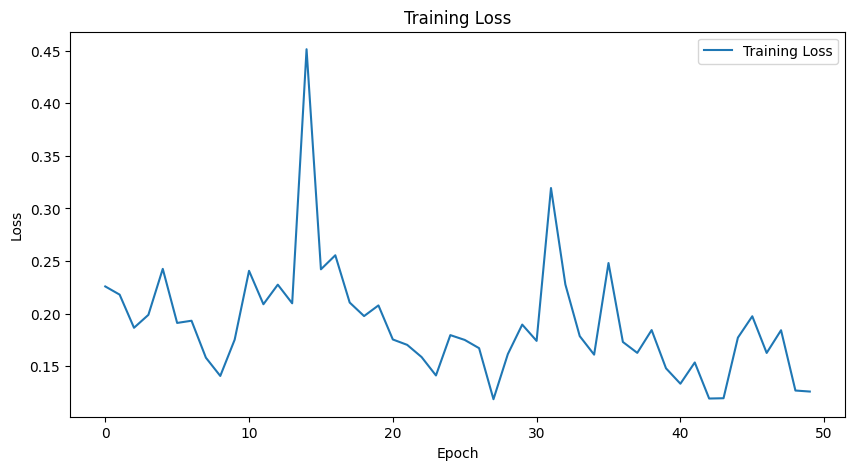

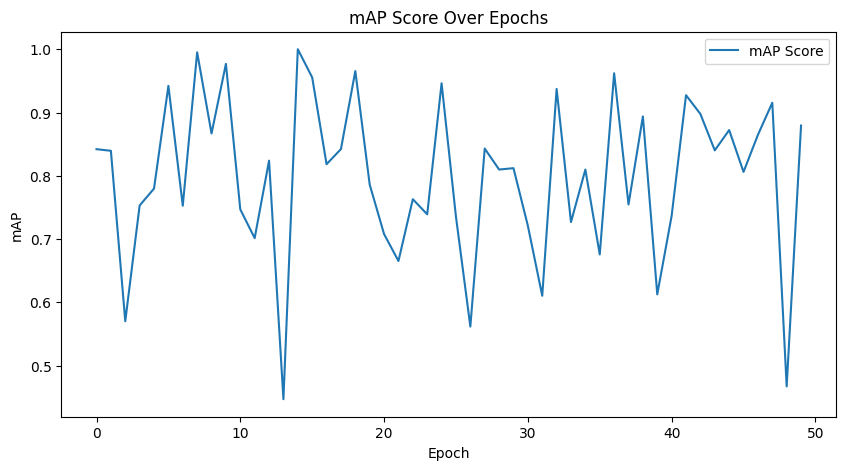

In [ ]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

# Plot the mAP scores
plt.figure(figsize=(10, 5))
plt.plot(map_scores, label='mAP Score')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.title('mAP Score Over Epochs')
plt.legend()
plt.show()

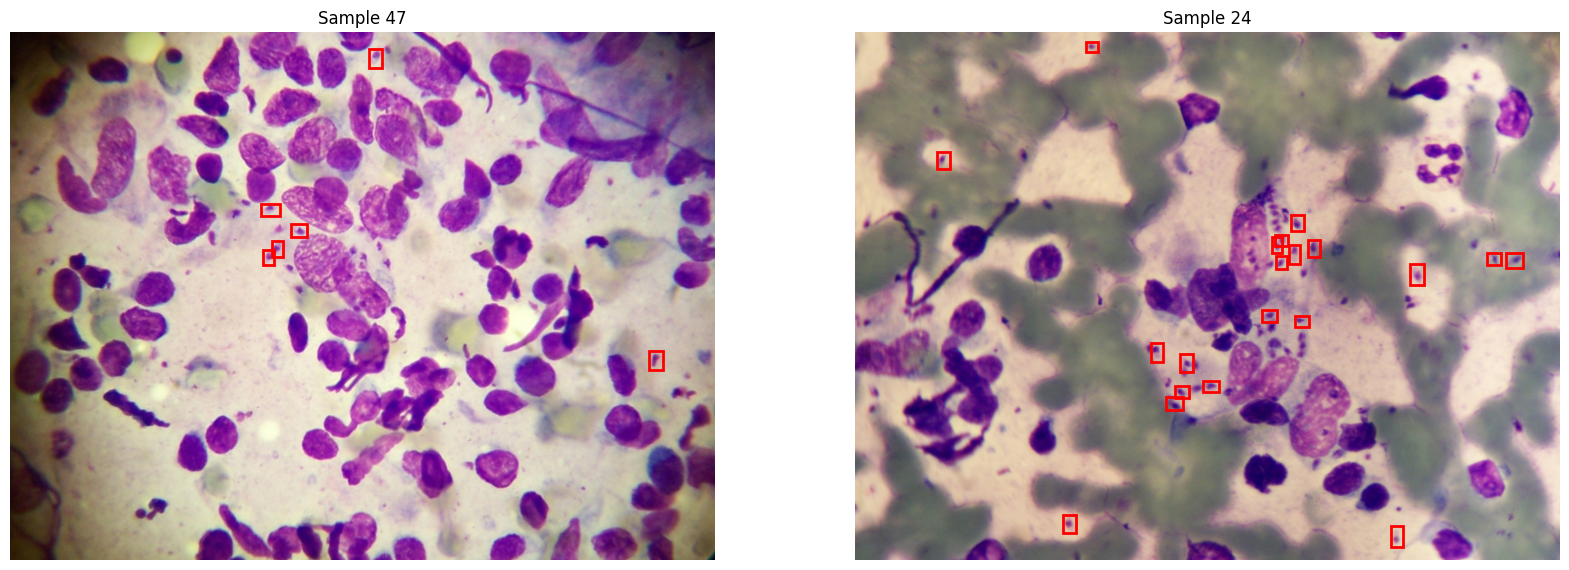

In [ ]:
def visualize_detections(model, dataset, indices):
    model.eval()
    fig, axes = plt.subplots(1, len(indices), figsize=(20, 10))

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # Load the image without normalization
            image, _ = dataset[idx]

            # Move image to device and make prediction
            image = image.to(device).unsqueeze(0)  # Add batch dimension
            output = model(image)[0]

            # Convert the tensor to a PIL Image for visualization
            original_image = TF.to_pil_image(image.squeeze(0))  # Remove batch dimension
            original_image_np = np.array(original_image)

            # Convert image to numpy array for visualization
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()

            for box, score in zip(boxes, scores):
                if score > 0.5:  # Show boxes with a confidence score > 0.5
                    x1, y1, x2, y2 = box
                    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='red', linewidth=2)
                    axes[i].add_patch(rect)
            axes[i].imshow(original_image_np)
            axes[i].set_title(f'Sample {idx}')
            axes[i].axis('off')

    plt.show()

# Visualize detections on some test samples
test_samples = random.sample(test_indices, 2)
visualize_detections(model, dataset, test_samples)